# USGS Water Use by County in 2015

#### The [U.S. Geological Survey's National Water-Use Science Project](https://water.usgs.gov/watuse/), compiles and reports water-use data for the nation.

-  Water-Use reports and data are published at 5 year intervals starting in 1950. The USGS published the most recent report [Estimated use of water in the United States in 2015](https://pubs.er.usgs.gov/publication/cir1441) in June, 2018. 
-  Along with this report the USGS released [Estimated Use of Water in the United States County-Level Data for 2015](https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8). We will use this dataset to get a sense for public and private drinking water-use in Vermont at the county-scale and how it compares to the rest of the Continental United States.

In [38]:
# Load necessary libraries
import sciencebasepy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#### Access relevant data
- Water use data from sciencebase using [sciencebasepy](https://github.com/usgs/sciencebasepy) module.
- US County spatial data from 2015 from [US Census](https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html)

In [39]:
sb = sciencebasepy.SbSession()

dataset_id = '5af3311be4b0da30c1b245d8'

# Get a public item.  No need to log in.
item_json = sb.get_item(dataset_id)

# Find csv path in attached files
url = [file for file in item_json['files'] if 'csv' in file['name']][0]['url']

# Read csv into dataframe
water_use_2015 = pd.read_csv(url, header = 1)

In [40]:
water_use_2015.head()

,STATE,STATEFIPS,COUNTY,COUNTYFIPS,FIPS,YEAR,TP-TotPop,PS-GWPop,PS-SWPop,PS-TOPop,...,TO-WGWTo,TO-WSWFr,TO-WSWSa,TO-WSWTo,TO-WFrTo,TO-WSaTo,TO-Wtotl,TO-CUsFrPartial,TO-CUsSaPartial,TO-CUTotPartial
0,AL,1,Autauga County,1,1001,2015,55.347,--,--,48.998,...,10.69,45.72,0.0,45.72,56.41,0.0,56.41,13.18,0.0,13.18
1,AL,1,Baldwin County,3,1003,2015,203.709,--,--,174.907,...,73.38,11.32,0.0,11.32,84.70,0.0,84.70,58.28,0.0,58.28
2,AL,1,Barbour County,5,1005,2015,26.489,--,--,24.587,...,6.06,2.96,0.0,2.96,9.02,0.0,9.02,2.96,0.0,2.96
3,AL,1,Bibb County,7,1007,2015,22.583,--,--,20.947,...,5.67,0.20,0.0,0.20,5.87,0.0,5.87,0.19,0.0,0.19
4,AL,1,Blount County,9,1009,2015,57.673,--,--,44.815,...,4.64,55.43,0.0,55.43,60.07,0.0,60.07,1.08,0.0,1.08


The column names for the water use files are somewhat cryptic so we will also create a dictionary from the Data Dictionary in the excel file for reference

In [41]:
# The column names are somewhat cryptic so we will also create a dictionary from the Data Dictionary in the excel file 
# for reference
excel_url = [file for file in item_json['files'] if 'xlsx' in file['name']][0]['url']
water_use_dict = (pd.read_excel(excel_url, sheet_name = 'DataDictionary')).set_index('Column Tag').T.to_dict('list')

In [42]:
# Glance at the keys and values in the data dictionary
dict(list(water_use_dict.items())[0:12])

{'STATE': ['State postal abbreviation'],
 'STATEFIPS': ['State FIPS code'],
 'COUNTY': ['County name'],
 'COUNTYFIPS': ['County FIPS code'],
 'FIPS': ['Concatenated State-county FIPS code'],
 'YEAR': ['Year of data=2015'],
 'TP-TotPop': ['Total population of county, in thousands'],
 'PS-GWPop': ['Public Supply, population served by groundwater, in thousands'],
 'PS-SWPop': ['Public Supply, population served by surface water, in thousands'],
 'PS-TOPop': ['Public Supply, total population served, in thousands'],
 'PS-WGWFr': ['Public Supply,  groundwater withdrawals, fresh, in Mgal/d'],
 'PS-WGWSa': ['Public Supply, groundwater withdrawals, saline, in Mgal/d']}

In [43]:
# Examine the full desciption of an abbreviation by accessing the value for any abbreviation 
water_use_dict['PS-WGWFr']

['Public Supply,  groundwater withdrawals, fresh, in Mgal/d']

#### Use geopandas to create geodataframes of US counties in 2015
- For the moment I will do this using a locally hosted shapefile downloaded from the link above. 
- An improvement would be to read it directly from the Census FTP site following [Agaidus Python Notebook - Reading Zipped Shapefiles](https://github.com/agaidus/census_data_extraction/blob/master/Reading_Zipped_Shapefiles.ipynb)
- Or from the github repo

In [44]:
# Read in shapefiles
counties_shp_path = r"C:\Users\colin.dowey\OneDrive - State of Vermont\MyFiles\GIS\GeneralGISFiles\shapefiles\US_County_500k_2015\cb_2015_us_county_500k.shp"
counties = gpd.read_file(counties_shp_path)

VTcounties = counties[counties['STATEFP'] == '50']

#### Join water-use data to counties geodataframe
- The join is based on the [County FIPS code](https://www.census.gov/geographies/reference-files/2015/demo/popest/2015-fips.html) which is contained in both datasets. Some slight alterations are needed to build the water-use County FIPS codes to match the Census shapefile format.

In [45]:
# Convert FIPS to text in Water Use Dataframe, if only four characters add leading zero
water_use_2015['FIPS'] = water_use_2015['FIPS'].astype(str)
water_use_2015['FIPS'] = [('0' + a) if len(a) == 4 else a for a in water_use_2015['FIPS']]

# Join water-use dataframe to geodataframe using merge. 
# For the result to be a geodataframe the geodataframe has to be on the left
US_county_water_use = counties.merge(water_use_2015, how = 'left', left_on = 'GEOID', right_on = 'FIPS')
not_joined = US_county_water_use[US_county_water_use['COUNTYFIPS'].isnull()]

Examine the success of this join. Do all counties from the shapefile correspond to a county in the water-use dataset? Where are the counties that did not have a corresponding match?

In [46]:
not_joined = US_county_water_use[US_county_water_use['COUNTYFIPS'].isnull()]
set(list(not_joined['STATEFP']))

{'60', '66', '69'}

The 'un-joined' counties are from American Samoa (60), Guam (66), and Commonwealth of the Northern Mariana Islands (69). We are going to focus only on the continental United States.

In [47]:
US_county_water_use = US_county_water_use[~US_county_water_use['COUNTYFIPS'].isnull()]

#### Water-Use Data

The two water-use measurements I am most interested in at the moment are: 
- Percentage of Population served by Private Water Supplies
- Percentage of Population served by Public Water Supplies

These values are currently not in the dataset so they must be calculated before plotted. Remeber the populations in this dataset are in thousands.

In [48]:
# The relevant columns in the water-use dataset
columns = ['TP-TotPop', 'DO-SSPop', 'PS-TOPop']
# Corresponding descriptions
for column in columns:
    print(column +' = ' + str(water_use_dict[column]))

TP-TotPop = ['Total population of county, in thousands']
DO-SSPop = ['Domestic, self-supplied population, in thousands']
PS-TOPop = ['Public Supply, total population served, in thousands']


In [49]:
# Check that for all counties the drinking water for the entire population comes from these two sources (Private or Public)
print(sum(round(US_county_water_use['DO-SSPop'] + US_county_water_use['PS-TOPop'] - US_county_water_use['TP-TotPop'], 3)))

0.0


In [50]:
#Calculate percentage of population served by private water supplies in each county
US_county_water_use['Per_Private'] = US_county_water_use['DO-SSPop']/US_county_water_use['TP-TotPop']*100

#Calculate percentage of population served by public water supplies in each county
US_county_water_use['Per_Public'] = US_county_water_use['PS-TOPop']/US_county_water_use['TP-TotPop']*100

#Update dictionary
water_use_dict['Per_Private'] = '[Percentage of Population served by private water supplies]'
water_use_dict['Per_Public'] = '[Percentage of Population served by public water supplies]'

## Mapping
#### Coordinate Systems
When creating a map and using spatial data it is important to think about the coordinate reference system (crs) of your data and what crs you want to use. 
One of my favorite resources for crs and projections is [epsg.io](http://epsg.io).

- The US_county_water_use geodataframe has [NAD83](http://epsg.io/4269) coordinate system.
- For visualization of the entire Continental United States it is converted to [North America Lambert Conformal Conic](https://epsg.io/102009) using a projection string
- Also define the projection string for [Vermont State Plane NAD83 (Feet)](https://epsg.io/102745) for later use plotting Vermont county data

In [51]:
# Find out what coordinate reference system the US_county_water_use the geodataframe has
print('Initial Coordinate System = ' + str(US_county_water_use.crs))

#From epsg.io we know this is the Geodetic coordinate system NAD83

US_county_water_use = US_county_water_use.to_crs("+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96" 
                                                 "+x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")
print('New Coordinate System = ' + US_county_water_use.crs)
VT_SP_NAD83_Feet_proj_str = ('+proj=tmerc +lat_0=42.5 +lon_0=-72.5 '
                            '+k=0.9999642857142857 +x_0=500000.0000000002 +y_0=0 '
                            '+ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs')

Initial Coordinate System = {'init': 'epsg:4269'}
New Coordinate System = +proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96+x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs


#### Creating Figures
The resulting figure will be a map of the continental US and a map of Vermont. Both maps will be chloropleth maps with shades of blue representing the Percentage of the Population in each county served by either private or public water supplies.

In [52]:
#Remove Alaska, Hawaii, Puerto Rico, and US Virgin Islands
remove_regions = ['02', '15', '72', '78']
US_county_water_use = US_county_water_use.loc[~(US_county_water_use['STATEFP'].isin(remove_regions))]

# Filter for Vermont counties
Vermont_water_use_2015 = US_county_water_use[US_county_water_use['STATE'] == 'VT']

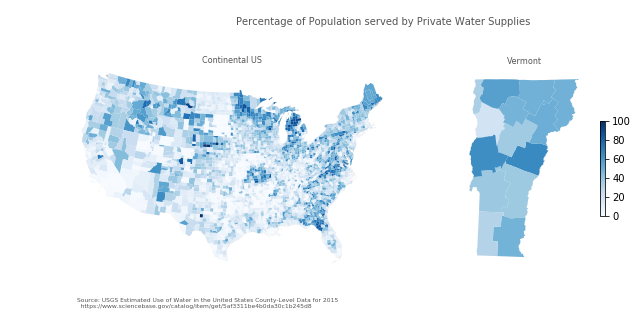

In [53]:
# Create Figure and subplots
plt.rcParams['figure.figsize'] = 10, 5
fig = plt.figure()

ax1 = plt.subplot2grid((10,10), (0,0), rowspan = 10, colspan = 6)
ax2 = plt.subplot2grid((10,10), (0, 7), rowspan = 10, colspan = 3)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

vmin, vmax = 0, 100     #These values set the max and min of the color ramp and allow it to be repeated over multple plots

# Plot Chloropleth map of water use by county for continental US on ax1
US_county_water_use.plot(column = 'Per_Private', ax = ax1, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)

# Plot outline of Continental US
# Dissolve geodataframe to single geometry called Con_US_Outline
US_county_water_use['Dissolve'] = 1
Con_US_Outline = US_county_water_use.dissolve('Dissolve')
# Plot outline
Con_US_Outline.plot(ax = ax1, facecolor="none", edgecolor = '#bfbfbf', linewidth = 0.05)

# Plot Chloropleth map of water use by county for vermont on ax2
# Reproject Vermont geometry to Vermont State Plane 1983 Feet
Vermont_water_use_2015 = Vermont_water_use_2015.to_crs(VT_SP_NAD83_Feet_proj_str)
Vermont_water_use_2015['Dissolve'] = 1
VT = Vermont_water_use_2015.dissolve('Dissolve')

# Plot Vermont chloropleth and Vermont state outline on ax2
Vermont_water_use_2015.plot(column = 'Per_Private', ax = ax2, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
VT.plot(ax = ax2, facecolor = 'none', edgecolor = '#bfbfbf', linewidth = 0.05)

#remove axis
ax1.axis('off')
ax2.axis('off')
#Add annotation
ax1.set_title('Continental US', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', pad = 0.5, fontsize=8)
ax2.set_title('Vermont', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', fontsize=8)
ax1.annotate('Source: USGS Estimated Use of Water in the United States County-Level Data for 2015\n  '
             'https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8', xy=(0.12, 0.10),  
             xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=6, color='#555555')
ax1.annotate('Percentage of Population served by Private Water Supplies', xy=(0.6, 0.95),  
             xycoords='figure fraction', horizontalalignment='center', verticalalignment='top', fontsize=10, color='#555555')
                    
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, orientation = 'vertical', shrink = 0.35, pad = 0.1)

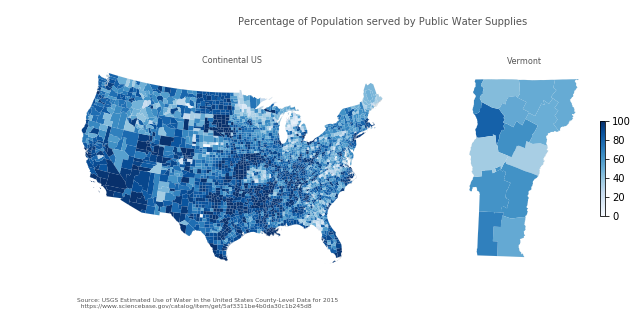

In [54]:
fig2 = plt.figure()

ax1 = plt.subplot2grid((10,10), (0,0), rowspan = 10, colspan = 6)
ax2 = plt.subplot2grid((10,10), (0, 7), rowspan = 10, colspan = 3)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

vmin, vmax = 0, 100     #These values set the max and min of the color ramp and allow it to be repeated over multple plots

# Plot Chloropleth map of water use by county for continental US on ax1
US_county_water_use.plot(column = 'Per_Public', ax = ax1, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
Con_US_Outline.plot(ax = ax1, facecolor="none", edgecolor = '#bfbfbf', linewidth = 0.05)

Vermont_water_use_2015.plot(column = 'Per_Public', ax = ax2, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
VT.plot(ax = ax2, facecolor = 'none', edgecolor = '#bfbfbf', linewidth = 0.05)

#remove axis
ax1.axis('off')
ax2.axis('off')
#Add annotation
ax1.set_title('Continental US', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', pad = 0.5, fontsize=8)
ax2.set_title('Vermont', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', fontsize=8)
ax1.annotate('Source: USGS Estimated Use of Water in the United States County-Level Data for 2015\n  '
             'https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8', xy=(0.12, 0.10),  
             xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=6, color='#555555')
ax1.annotate('Percentage of Population served by Public Water Supplies', xy=(0.6, 0.95),  
             xycoords='figure fraction', horizontalalignment='center', verticalalignment='top', fontsize=10, color='#555555')
                    
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig2.colorbar(sm, orientation = 'vertical', shrink = 0.35, pad = 0.1)

Create another set of maps that compare the percentage of the population in each Vermont county that use private and public water supplies. 
- This map will use labels to display the corresponding values for each Vermont county.

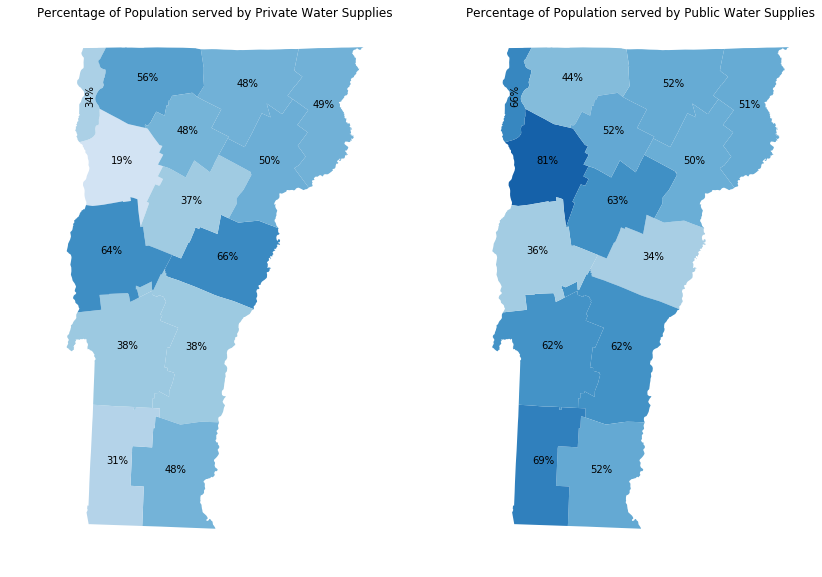

In [55]:
plt.rcParams['figure.figsize'] = 15, 15
fig3 = plt.figure()

ax1 = plt.subplot2grid((10,10), (0, 0), rowspan = 10, colspan = 4)
ax2 = plt.subplot2grid((10,10), (0, 5), rowspan = 10, colspan = 4)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Percentage of Population served by Private Water Supplies')
ax2.set_title('Percentage of Population served by Public Water Supplies')


Vermont_water_use_2015.plot(column = 'Per_Private', ax = ax1, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
Vermont_water_use_2015.plot(column = 'Per_Public', ax = ax2, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)

# Use the geopandas method centroid to create coordinates for label placement
# Round the values to the nearest tenth of a percent
Vermont_water_use_2015['Per_Private'] = Vermont_water_use_2015['Per_Private'].round().astype('int')
Vermont_water_use_2015['Per_Public'] = Vermont_water_use_2015['Per_Public'].round().astype('int')
#Dictionary for label rotation
label_rot = dict(zip(Vermont_water_use_2015['NAME'],[0] * len(Vermont_water_use_2015)))
label_rot['Grand Isle'] = 90

Vermont_water_use_2015.apply(lambda x: ax1.annotate(s=((str(x.Per_Private)) + '%'), 
                                                    xy=x.geometry.centroid.coords[0], 
                                                    rotation = label_rot[x.NAME],
                                                    ha='center'), axis=1);
Vermont_water_use_2015.apply(lambda x: ax2.annotate(s=((str(x.Per_Public)) + '%'), 
                                                    xy=x.geometry.centroid.coords[0], 
                                                    rotation = label_rot[x.NAME],
                                                    ha='center'), axis=1);